In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
import copy
import matplotlib
import plotly.graph_objs as go
import plotly.offline as pyo

In [36]:
def compute_weight(G, edge_coeff, tri_coeff):
    '''
    Compute the probability weight on graph G
    '''
    edge_count = len(G.edges())
    triangles = sum(nx.triangles(G).values())
    return np.exp(edge_count * edge_coeff + triangles * tri_coeff)

In [37]:
def permute_graph(G):
    '''
    Return a new graph with an edge randomly added or subtracted from G
    '''
    G1 = copy.deepcopy(G)
    d = nx.density(G1)
    r = random.random()
    if (r < 0.5 or d == 0) and d != 1:
        # Add an edge
        nodes = G.nodes()
        n1 = random.choice(nodes)
        n2 = random.choice(nodes)
        G1.add_edge(n1, n2)
    else:
        # Remove an edge
        n1, n2 = random.choice(G1.edges())
        G1.remove_edge(n1, n2)
    return G1


In [38]:
def mcmc(G, edge_coeff, triangle_coeff, n):
    '''
    Use MCMC to generate a sample of networks from an ERG distribution.

    Args:
        G: The observed network, to seed the graph with
        edge_coeff: The coefficient on the number of edges
        triangle_coeff: The coefficient on number of triangles
        n: The number of samples to generate
    Returns:
        A list of graph objects
    '''

    v = len(G) # number of nodes in G
    p = nx.density(G) # Probability of a random edge existing
    current_graph = nx.erdos_renyi_graph(v, p) # Random graph
    current_w = compute_weight(G, edge_coeff, triangle_coeff)
    graphs = []
    while len(graphs) < n:
        new_graph = permute_graph(current_graph)
        new_w = compute_weight(new_graph, edge_coeff, triangle_coeff)
        if new_w > current_w or random.random() < (new_w/current_w):
            graphs.append(new_graph)
            current_w = new_w
    return graphs

In [39]:
def sum_weights(graphs, edge_coeff, tri_coeff):
    '''
    Sum the probability weights on every graph in graphs
    '''
    total = 0.0
    for g in graphs:
        total += compute_weight(g, edge_coeff, tri_coeff)
    return total

In [40]:
def fit_ergm(G, coeff_samples=100, graph_samples=1000, return_all=False):
    '''
    Use MCMC to sample possible coefficients, and return the best fits.

    Args:
        G: The observed graph to fit
        coeff_samples: The number of coefficient combinations to sample
        graph_samples: The number of graphs to sample for each set of coeffs
        return_all: If True, return all sampled values. Otherwise, only best.
    Returns:
        If return_all=False, returns a tuple of values,
            (best_edge_coeff, best_triangle_coeff, best_p)
        where p is the estimated probability of observing the graph G with
        the fitted parameters.

        Otherwise, return a tuple of lists:
            (edge_coeffs, triangle_coeffs, probs)
    '''
    edge_coeffs = [0]
    triangle_coeffs = [0]
    probs = [None]

    while len(probs) < coeff_samples:
        # Make the jump size larger early on, and smaller toward the end
        w = coeff_samples/50.0
        s = np.sqrt(w/len(probs))
        # Pick new coefficients to try:
        edge_coeff = edge_coeffs[-1] +  random.normalvariate(0, s)
        triangle_coeff = triangle_coeffs[-1] + random.normalvariate(0, s)
        # Check how likely the observed graph is under this distribution:
        graphs = mcmc(G, edge_coeff, triangle_coeff, graph_samples)
        sum_weight = sum_weights(graphs, edge_coeff, triangle_coeff)
        p = compute_weight(G, edge_coeff, triangle_coeff) / sum_weight
        # Decide whether to accept the jump:
        if p > probs[-1] or random.random() < (p / probs[-1]):
            edge_coeffs.append(edge_coeff)
            triangle_coeffs.append(triangle_coeff)
            probs.append(p)
        else:
            edge_coeffs.append(edge_coeffs[-1])
            triangle_coeffs.append(triangle_coeffs[-1])
            probs.append(probs[1])
    # Return either the best values, or all of them:
    if not return_all:
        i = np.argmax(probs)
        best_p = probs[i]
        best_edge_coeff = edge_coeffs[i]
        best_triangle_coeff = triangle_coeffs[i]
        return (best_edge_coeff, best_triangle_coeff, best_p)
    else:
        return (edge_coeffs, triangle_coeffs, probs)

In [41]:
data = pd.read_csv('trade_data_rice.csv', index_col=0)

In [42]:
data

,year,exporter,importer,product,value,quantity,exporter_name,importer_name,product_description
35877,2022,24,516,100610,0.022,0.035,Angola,Namibia,Cereals: rice in the husk (paddy or rough)
50288,2022,32,56,100610,4.740,2.242,Argentina,Belgium,Cereals: rice in the husk (paddy or rough)
52467,2022,32,76,100610,29.252,9.000,Argentina,Brazil,Cereals: rice in the husk (paddy or rough)
54794,2022,32,152,100610,38.444,79.219,Argentina,Chile,Cereals: rice in the husk (paddy or rough)
76608,2022,32,724,100610,0.063,0.011,Argentina,Spain,Cereals: rice in the husk (paddy or rough)
...,...,...,...,...,...,...,...,...,...
10800041,2022,858,862,100610,47877.581,141800.000,Uruguay,Venezuela,Cereals: rice in the husk (paddy or rough)
10803316,2022,860,398,100610,2.727,3.000,Uzbekistan,Kazakhstan,Cereals: rice in the husk (paddy or rough)
10804935,2022,860,417,100610,88.625,31.000,Uzbekistan,Kyrgyzstan,Cereals: rice in the husk (paddy or rough)
10820865,2022,894,516,100610,0.314,0.770,Zambia,Namibia,Cereals: rice in the husk (paddy or rough)


In [43]:
edges = data[['exporter_name','importer_name','value']].copy().reset_index(drop=True)

In [44]:
edges

,exporter_name,importer_name,value
0,Angola,Namibia,0.022
1,Argentina,Belgium,4.740
2,Argentina,Brazil,29.252
3,Argentina,Chile,38.444
4,Argentina,Spain,0.063
...,...,...,...
1078,Uruguay,Venezuela,47877.581
1079,Uzbekistan,Kazakhstan,2.727
1080,Uzbekistan,Kyrgyzstan,88.625
1081,Zambia,Namibia,0.314


In [45]:
# edges = pd.DataFrame({
#     'source': [1, 2, 3],
#     'target': [2, 3, 1],
#     'weight': [3.5, 2.1, 5.0]
# })

G_df = nx.from_pandas_edgelist(edges, 'exporter_name', 'importer_name', edge_attr='value')


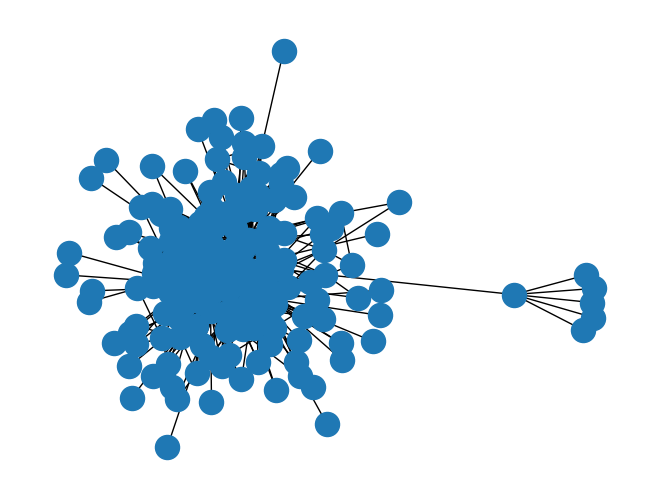

In [46]:
nx.draw(G_df)

In [48]:
# Generate positions using a layout
pos = nx.spring_layout(G_df)

# Extract node positions
x_nodes = [pos[k][0] for k in pos]
y_nodes = [pos[k][1] for k in pos]

# Create traces for edges
edge_trace = go.Scatter(
    x=sum([[pos[edge[0]][0], pos[edge[1]][0], None] for edge in G_df.edges()], []),
    y=sum([[pos[edge[0]][1], pos[edge[1]][1], None] for edge in G_df.edges()], []),
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Create trace for nodes
node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers+text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right'),
        size=10,
        line=dict(width=2)
    ),
    text=[f"Node: {node}" for node in G_df.nodes()],
    hoverinfo='text'
)

# Update node colors based on the number of connections (node degree)
node_adjacencies = [len(G_df.adj[node]) for node in G_df.nodes()]
node_trace.marker.color = node_adjacencies

# Set up layout
fig_layout = go.Layout(
    title='<br>Interactive Network Graph with Plotly and NetworkX',
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=30),
    annotations=[dict(
        text="Network Visualization",
        showarrow=False,
        xref="paper", yref="paper"
    )],
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace], layout=fig_layout)

# Render the graph
pyo.plot(fig, filename='network_graph.html')


'network_graph.html'

In [49]:
def mcmc(G, param1, param2, iterations):
    graphs = []
    for _ in range(iterations):
        G1 = copy.deepcopy(G)
        # Your MCMC operations on G1
        # Example operation, modify as per your actual operations:
        if random.random() < 0.5:
            G1.add_edge(random.randint(0, 99), random.randint(0, 99))
        graphs.append(G1)
    return graphs

graphs = mcmc(G, -1.25, 0.15, 100)

In [50]:
def fit_ergm(G, coeff_samples=100, graph_samples=1000, return_all=False):
    edge_coeffs = [0]
    triangle_coeffs = [0]
    probs = [1]  # Start with a non-None probability value

    for _ in range(coeff_samples):
        w = coeff_samples / 50.0
        s = np.sqrt(w / len(probs))
        edge_coeff = edge_coeffs[-1] + random.normalvariate(0, s)
        triangle_coeff = triangle_coeffs[-1] + random.normalvariate(0, s)
        
        graphs = mcmc(G, edge_coeff, triangle_coeff, graph_samples)
        sum_weight = sum_weights(graphs, edge_coeff, triangle_coeff)
        p = compute_weight(G, edge_coeff, triangle_coeff) / sum_weight
        
        if p > probs[-1] or random.random() < (p / probs[-1]):
            edge_coeffs.append(edge_coeff)
            triangle_coeffs.append(triangle_coeff)
            probs.append(p)
        else:
            edge_coeffs.append(edge_coeffs[-1])
            triangle_coeffs.append(triangle_coeffs[-1])
            probs.append(probs[-1])

    if not return_all:
        i = np.argmax(probs)
        return (edge_coeffs[i], triangle_coeffs[i], probs[i])
    else:
        return (edge_coeffs, triangle_coeffs, probs)

# Example usage
G = nx.gnm_random_graph(10, 20)  # Create a random graph
results = fit_ergm(G, 10, 10, True)
print(results)

([0, -0.1999857203344417, -0.6264147840399725, -0.7916778125955863, -0.3519889683785072, -0.10891940574738293, -0.5871079098648038, -0.6022685160598923, -0.8779956542098784, -0.7097228690908439, -0.7313602300914908], [0, 0.27662791766464007, 0.5029375808101046, 0.6314080477376278, 0.8480863242170211, 0.5408323075787624, 0.5283431130989817, 0.5317681395654396, 0.5331405782621222, 0.526836463918747, 0.6545367889840754], [1, 0.1078170629117465, 0.11623157627628118, 0.12800268918140015, 0.12165853752660864, 0.10319482856049658, 0.12854025822705067, 0.12923502705872375, 0.153995631891155, 0.12551584085156836, 0.11157591334181578])


In [51]:
edge_coeffs, triangle_coeffs, probs = fit_ergm(G, 100, 10, True)


In [52]:
i = np.argmax(probs)
print(max(probs))
print(edge_coeffs[i])
print(triangle_coeffs[i])


1
0
0


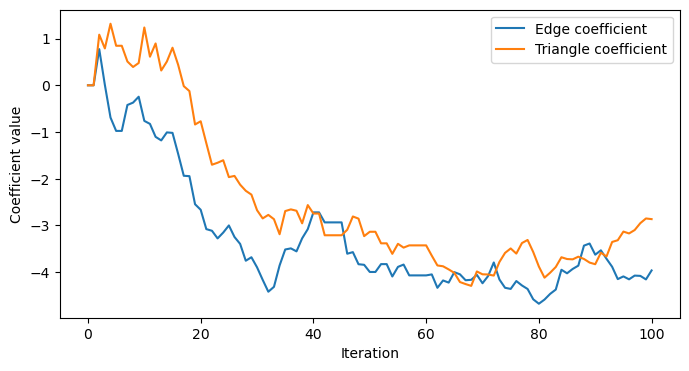

In [53]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
p1, = ax.plot(edge_coeffs)
p2, = ax.plot(triangle_coeffs)
ax.set_ylabel("Coefficient value")
ax.set_xlabel("Iteration")
l = ax.legend([p1, p2], ["Edge coefficient", "Triangle coefficient"])

In [54]:
weighted_edge_coeffs = np.array(edge_coeffs[1:]) * np.array(probs[1:])
print(np.sum(weighted_edge_coeffs)/np.sum(probs[1:]))

-3.24267002237649


In [55]:
weighted_tri_coeffs = np.array(triangle_coeffs[1:]) * np.array(probs[1:])
print(np.sum(weighted_tri_coeffs)/np.sum(probs[1:]))

-2.637127602489563


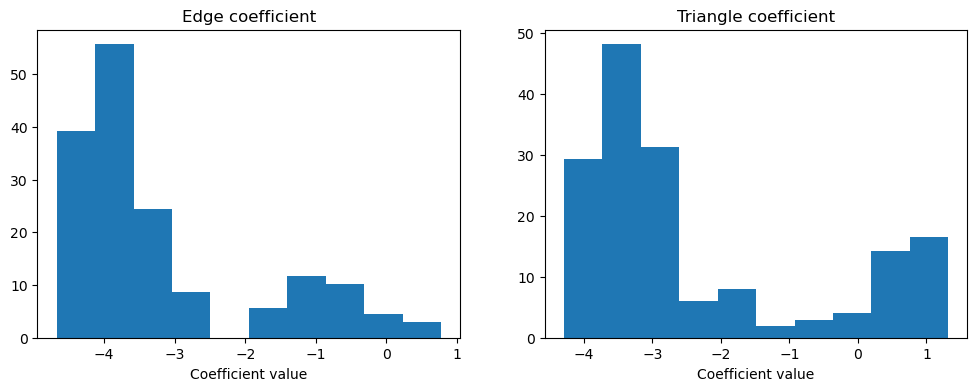

In [56]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.hist(edge_coeffs[1:], weights=-np.log(probs[1:]))
ax1.set_title("Edge coefficient")
ax1.set_xlabel("Coefficient value")

ax2 = fig.add_subplot(122)
ax2.hist(triangle_coeffs[1:], weights=-np.log(probs[1:]))
ax2.set_title("Triangle coefficient")
ax2.set_xlabel("Coefficient value")
plt.show()